<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 100px">

# Project 4a: Predict West Nile Virus

## Part 3 - Weather Dataset - Data Cleaning and EDA

### Contents:
- [Data Collection](#Data-Collection)
- [Data Cleaning](#Data-Cleaning)
    - [1. Dealing with Null Values](#1.-Deal-with-null-values)
        - [Drop Columns](#Dropping-Columns)
        - [Imputate Columns](#Imputation-of-rest-of-columns-with-only-a-few-rows-of-null-values)
            - [1. Tavg](#1.-The-column-'Tavg')
            - [2. Cool](#2.-The-column-'Cool')
            - [3. Heat](#3.-The-column-'Heat')
            - [4. SeaLevel](#4.-The-column-'SeaLevel')
            - [5. StnPressure](#5.-The-column-'StnPressure')
            - [6. WetBulb](#6.-The-column-'WetBulb')
            - [7. AvgSpeed](#7.-The-column-'AvgSpeed')
            - [8. PrecipTotal](#8.-The-column-'PrecipTotal')
    - [2. Check Data Types](#2.-Check-Data-Types)
    - [3. Feature Engineering](#3.-Feature-Engineering)
        - [Drop Columns](#Drop-Columns-to-Reduce-Multi-Collinearity)
        - [Modify Columns](#Modifications-of-Columns)
            - [1. CodeSum](#1.-The-column-'CodeSum')
            - [2. Date](#2.-The-column-'Date')
    - [4. Lowercasing Column Names](#4.-Lowercasing-Column-Names)
- [Save Dataset](#Save-the-Clean-Dataset)

## Data Collection

### Import all necessary libraries

In [1]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime as dt
import re
import string
import nltk

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

#hide warnings
import warnings
warnings.filterwarnings('ignore')

### Import Data from Weather.csv

In [2]:
# Import data into dataframe named weather
weather = pd.read_csv("../assets/weather.csv")

In [3]:
# Print the shape of dataframe
weather.shape

# There are 2944 rows and 22 columns

(2944, 22)

In [4]:
# Print a few rows to see the dataframe
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


## Data Cleaning

### 1. Deal with null values

In [5]:
# Check for null values
weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

From this aspect, there is no null value.

However, after looking at the few rows printed out of the dataframe above, observe there are null values being put as "M" or '-' in a few columns such as "Depart", "Depth", "Water1", "Sunrise" and "Sunset".

In [6]:
# Replace all the 'M' or '-' values to NaN
for col in weather:
    weather[col] = weather[col].apply(lambda value: np.nan if value == 'M' or value == '-' else value)

# Calculate the number of null values in each column, sorting in descending order
null_count = weather.isnull().sum().sort_values(ascending=False)

In [7]:
# Filter out those columns with 0 null values
null_count = null_count[null_count.values >0]

# Calculate null values in terms of percentage
null_count_percent = null_count/(len(weather)) * 100

# Create a dataframe as 'null_df'
null_df = pd.concat([null_count,null_count_percent], axis = 1, keys =['Total null values', 'Percentage of null values'])

In [8]:
# Print the dataframe
null_df

,Total null values,Percentage of null values
Water1,2944,100.000000
Sunset,1472,50.000000
Depth,1472,50.000000
Depart,1472,50.000000
SnowFall,1472,50.000000
Sunrise,1472,50.000000
Tavg,11,0.373641
Heat,11,0.373641
Cool,11,0.373641
SeaLevel,9,0.305707


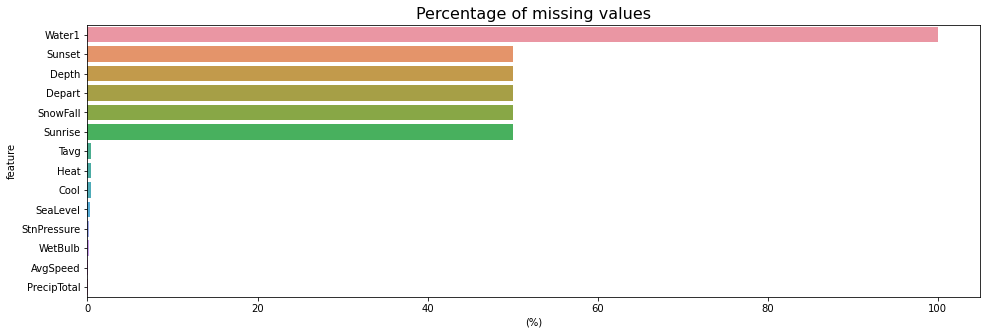

In [9]:
# Plot the missing values using a bar plot
fig, ax = plt.subplots(figsize=(16,5))
ax = sns.barplot(null_count_percent.values,null_count_percent.index);
ax.set_xlabel('(%)');
ax.set_ylabel('feature');
ax.set_title('Percentage of missing values', fontsize=16);

As the 6 columns 'Water1', 'Sunrise', 'Depart', 'Snowfall', 'Depth' and 'Sunset' have at least 50% of dataset of missing values, we feel that it would be good to drop these columns as imputation might skew the data.

#### Dropping Columns

In [10]:
# Drop the 6 columns
weather.drop(columns=['Water1', 'Sunrise', 'Depart', 'SnowFall', 'Depth', 'Sunset'], inplace=True)

In [11]:
# Check the shape
weather.shape

# Now there are 16 columns left

(2944, 16)

#### Imputation of rest of columns with only a few rows of null values

Remaining columns with missing values are:
1. Tavg	
2. Cool
3. Heat
4. SeaLevel
5. StnPressure
6. WetBulb		
7. AvgSpeed
8. PrecipTotal

We will imputate the values for the missing values in these columns as the missing values in these columns are less than 1%.

##### 1. The column 'Tavg'

In [12]:
# Check the data type of Tavg
weather['Tavg'].dtype

dtype('O')

The 'Tavg' column's values are in str format. For better visualisation during plotting, we will change the data type of the values to float.

In [13]:
# Changing the data types from str to float
weather['Tavg'] = weather['Tavg'].map(lambda value: float(value) if value != np.nan else value)

In [14]:
# Check again the data type of Tavg
weather['Tavg'].dtype

dtype('float64')

In [15]:
# Check the unique values in Tavg
np.unique(weather['Tavg'])

array([36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48.,
       49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61.,
       62., 63., 64., 65., 66., 67., 68., 69., 70., 71., 72., 73., 74.,
       75., 76., 77., 78., 79., 80., 81., 82., 83., 84., 85., 86., 87.,
       88., 89., 90., 91., 92., 93., 94., nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan])

In [16]:
# Replace all null values in 'Tavg' by averaging between the Tmax and Tmin of that row, as it is how Tavg is calculated.
weather.loc[weather['Tavg'].isnull(),'Tavg'] = (weather['Tmax'] + weather['Tmin'])/2

In [17]:
# Check whether there is still null value
weather['Tavg'].isnull().sum()

# No more null values.

0

##### 2. The column 'Cool'

In [18]:
# Check the data type of Cool
weather['Cool'].dtype

dtype('O')

The 'Cool' column's values are in str format. For better visualisation during plotting, we will change the data type of the values to float.

In [19]:
# Changing the data types from str to float
weather['Cool'] = weather['Cool'].map(lambda value: float(value) if value != np.nan else value)

In [20]:
# Check again the data type of Cool
weather['Cool'].dtype

dtype('float64')

In [21]:
# Check the unique values in Cool
np.unique(weather['Cool'])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

Before imputating any empty values in Cool, we will take a look at the distribution of the values in the Cool column.

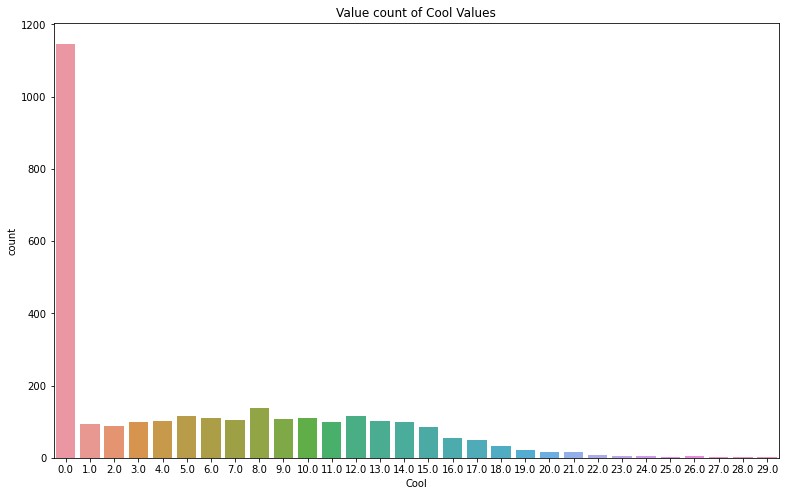

In [22]:
# Plot the value count of cool values
plt.figure(figsize=(13,8));
sns.countplot(weather['Cool'].sort_values(ascending = True));
plt.title('Value count of Cool Values');

As the 'Cool' column is made up of discrete values, we will take the value that is the most frequent to impute into the NULL cells.

The countplot above shows that the value 0 appears much more frequently than the other values. Therefore, we decided to replace the NULL values in the 'Cool' column with 0.

In [23]:
# Replace null value in 'Cool' to zero
weather['Cool'] = weather['Cool'].fillna(0)

In [24]:
# Check whether there is still null value
weather['Cool'].isnull().sum()

# No more null values.

0

##### 3. The column 'Heat'

In [25]:
# Check the data type of Heat
weather['Heat'].dtype

dtype('O')

The 'Heat' column's values are in str format. For better visualisation during plotting, we will change the data type of the values to float.

In [26]:
# Changing the data types from str to float
weather['Heat'] = weather['Heat'].map(lambda value: float(value) if value != np.nan else value)

In [27]:
# Check again the data type of Heat
weather['Heat'].dtype

dtype('float64')

In [28]:
# Check the unique values in Heat
np.unique(weather['Heat'])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

Before imputating any empty values in Heat, we will take a look at the distribution of the values in the Heat column.

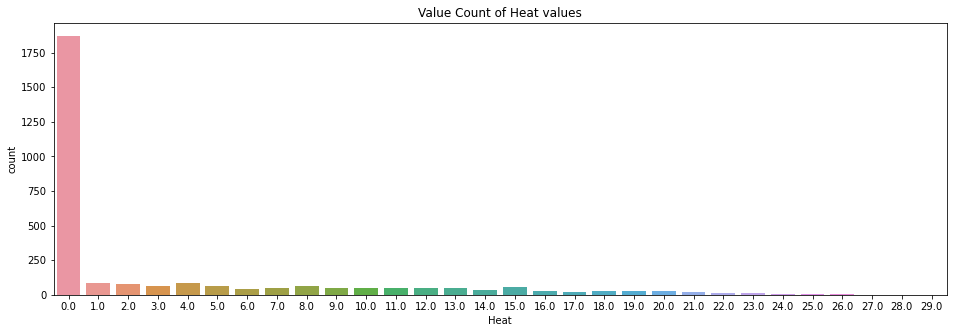

In [29]:
# Plot count of each value
plt.figure(figsize=(16,5));
sns.countplot(weather['Heat'].sort_values(ascending=True));
plt.title('Value Count of Heat values');

plt.show();

As the 'Heat' column is made up of discrete values, we will take the value that is the most frequent to impute into the NULL cells.

The countplot above shows that the value 0 appears much more frequently than the other values. Therefore, we decided to replace the NULL values in the 'Heat' column with 0.

In [30]:
# Fill all NULL values with 0
weather['Heat'] = weather['Heat'].fillna(0)

# Check whether there is still null value
print('Number of NULL values in "Heat" column:', weather['Heat'].isnull().sum())

# Reheck the unique values in Heat
np.unique(weather['Heat'])

Number of NULL values in "Heat" column: 0


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.])

##### 4. The column 'SeaLevel'

In [31]:
# Check the data type of SeaLevel
weather['SeaLevel'].dtype

dtype('O')

The 'SeaLevel' column's values are in str format. For better visualisation during plotting, we will change the data type of the values to float.

In [32]:
# Changing the data types from str to float
weather['SeaLevel'] = weather['SeaLevel'].map(lambda value: float(value) if value != np.nan else value)

In [33]:
# Check again the data type of SeaLevel
weather['SeaLevel'].dtype

dtype('float64')

In [34]:
# Check the unique values in SeaLevel
np.unique(weather['SeaLevel'])

array([29.23, 29.25, 29.34, 29.43, 29.44, 29.45, 29.46, 29.47, 29.48,
       29.5 , 29.51, 29.52, 29.53, 29.54, 29.55, 29.56, 29.59, 29.6 ,
       29.61, 29.62, 29.63, 29.64, 29.65, 29.66, 29.67, 29.68, 29.69,
       29.7 , 29.71, 29.72, 29.73, 29.74, 29.75, 29.76, 29.77, 29.78,
       29.79, 29.8 , 29.81, 29.82, 29.83, 29.84, 29.85, 29.86, 29.87,
       29.88, 29.89, 29.9 , 29.91, 29.92, 29.93, 29.94, 29.95, 29.96,
       29.97, 29.98, 29.99, 30.  , 30.01, 30.02, 30.03, 30.04, 30.05,
       30.06, 30.07, 30.08, 30.09, 30.1 , 30.11, 30.12, 30.13, 30.14,
       30.15, 30.16, 30.17, 30.18, 30.19, 30.2 , 30.21, 30.22, 30.23,
       30.24, 30.25, 30.26, 30.27, 30.28, 30.29, 30.3 , 30.31, 30.32,
       30.33, 30.34, 30.35, 30.36, 30.37, 30.38, 30.39, 30.4 , 30.41,
       30.52, 30.53,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan])

Before imputating any empty values in SeaLevel, we will take a look at the distribution of the values in the SeaLevel column.

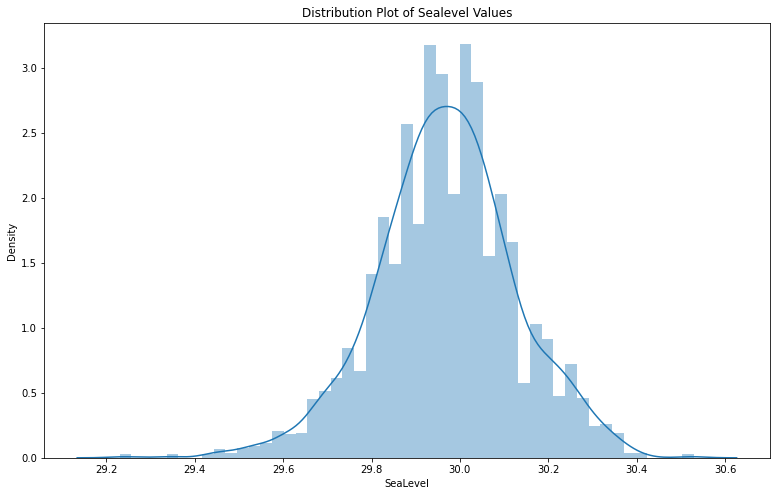

In [35]:
# Plot the distribution of sealevel values
plt.figure(figsize=(13,8));
sns.distplot(weather['SeaLevel'].sort_values(ascending = True));
plt.title('Distribution Plot of Sealevel Values');

Based on the above distribution plot, the sea level is a range of continuous numbers, and having a median at quite the center of the distribution. As such, we will use the median to replace the null values.

In [36]:
# Replacing Sealevel null values with median
weather['SeaLevel'] = weather['SeaLevel'].fillna(weather['SeaLevel'].median())

In [37]:
# Check whether there is still null value
weather['SeaLevel'].isnull().sum()

# No more null values.

0

##### 5. The column 'StnPressure'

In [38]:
# Check the data type of StnPressure
weather['StnPressure'].dtype

dtype('O')

The 'StnPressure' column's values are in str format. For better visualisation during plotting, we will change the data type of the values to float.

In [39]:
# Changing the data types from str to float
weather['StnPressure'] = weather['StnPressure'].map(lambda value: float(value) if value != np.nan else value)

In [40]:
# Check again the data type of StnPressure
weather['StnPressure'].dtype

dtype('float64')

In [41]:
# Check the unique values in StnPressure
np.unique(weather['StnPressure'])

array([28.55, 28.59, 28.63, 28.67, 28.69, 28.71, 28.73, 28.74, 28.75,
       28.77, 28.79, 28.8 , 28.81, 28.82, 28.83, 28.84, 28.85, 28.87,
       28.88, 28.89, 28.9 , 28.91, 28.92, 28.93, 28.94, 28.95, 28.96,
       28.97, 28.98, 28.99, 29.  , 29.01, 29.02, 29.03, 29.04, 29.05,
       29.06, 29.07, 29.08, 29.09, 29.1 , 29.11, 29.12, 29.13, 29.14,
       29.15, 29.16, 29.17, 29.18, 29.19, 29.2 , 29.21, 29.22, 29.23,
       29.24, 29.25, 29.26, 29.27, 29.28, 29.29, 29.3 , 29.31, 29.32,
       29.33, 29.34, 29.35, 29.36, 29.37, 29.38, 29.39, 29.4 , 29.41,
       29.42, 29.43, 29.44, 29.45, 29.46, 29.47, 29.48, 29.49, 29.5 ,
       29.51, 29.52, 29.53, 29.54, 29.55, 29.56, 29.57, 29.58, 29.59,
       29.6 , 29.61, 29.62, 29.63, 29.64, 29.65, 29.66, 29.67, 29.68,
       29.7 , 29.71, 29.79, 29.86,   nan,   nan,   nan,   nan])

Before imputating any empty values in StnPressure, we will take a look at the distribution of the values in the StnPressure column.

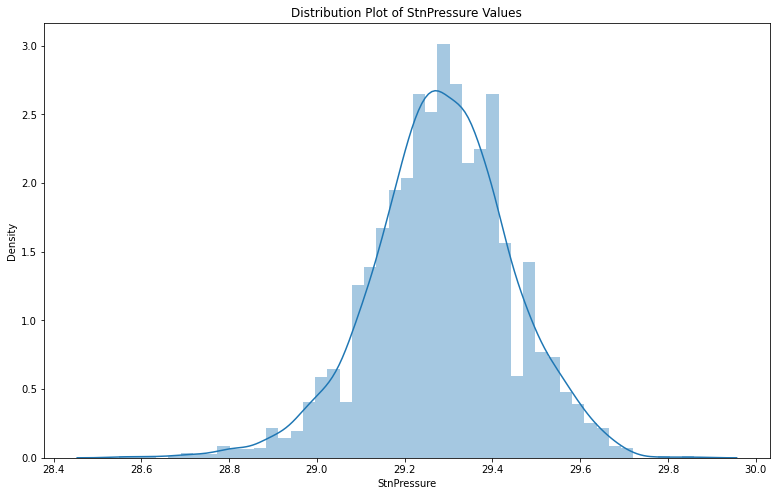

In [42]:
# Plot the distribution of StnPressure values
plt.figure(figsize=(13,8));
sns.distplot(weather['StnPressure'].sort_values(ascending = True));
plt.title('Distribution Plot of StnPressure Values');

Based on the above distribution plot, the StnPressure is a range of continuous numbers, and having a median at quite the center of the distribution. As such, we will use the median to replace the null values.

In [43]:
# Replacing StnPressure null values with median
weather['StnPressure'] = weather['StnPressure'].fillna(weather['StnPressure'].median())

In [44]:
# Check whether there is still null value
weather['StnPressure'].isnull().sum()

# No more null values.

0

##### 6. The column 'WetBulb'

In [45]:
# Check the data type of WetBulb
weather['WetBulb'].dtype

dtype('O')

The 'WetBulb' column's values are in str format. For better visualisation during plotting, we will change the data type of the values to float.

In [46]:
# Changing the data types from str to float
weather['WetBulb'] = weather['WetBulb'].map(lambda value: float(value) if value != np.nan else value)

In [47]:
# Check again the data type of WetBulb
weather['WetBulb'].dtype

dtype('float64')

In [48]:
# Check the unique values in WetBulb
np.unique(weather['WetBulb'])

array([32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44.,
       45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56., 57.,
       58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70.,
       71., 72., 73., 74., 75., 76., 77., 78., nan, nan, nan, nan])

Before imputating any empty values in WetBulb, we will take a look at the distribution of the values in the WetBulb column.

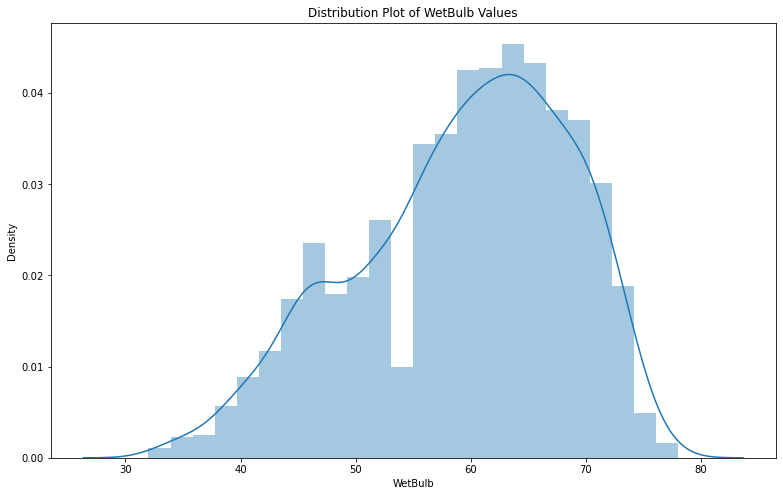

In [49]:
# Plot the distribution of WetBulb values
plt.figure(figsize=(13,8));
sns.distplot(weather['WetBulb'].sort_values(ascending = True));
plt.title('Distribution Plot of WetBulb Values');

Based on the above distribution plot, the WetBulb is a range of continuous numbers, and having a median at quite the center of the distribution. As such, we will use the median to replace the null values.

In [50]:
# Replacing WetBulb null values with median
weather['WetBulb'] = weather['WetBulb'].fillna(weather['WetBulb'].median())

In [51]:
# Check whether there is still null value
weather['WetBulb'].isnull().sum()

# No more null values.

0

##### 7. The column 'AvgSpeed'

In [52]:
# Check the data type of AvgSpeed
weather['AvgSpeed'].dtype

dtype('O')

The 'AvgSpeed' column's values are in str format. For better visualisation during plotting, we will change the data type of the values to float.

In [53]:
# Changing the data types from str to float
weather['AvgSpeed'] = weather['AvgSpeed'].map(lambda value: float(value) if value != np.nan else value)

In [54]:
# Check again the data type of AvgSpeed
weather['AvgSpeed'].dtype

dtype('float64')

In [55]:
# Check the unique values in AvgSpeed
np.unique(weather['AvgSpeed'])

array([ 1.7,  1.9,  2. ,  2.1,  2.3,  2.4,  2.6,  2.7,  2.8,  2.9,  3. ,
        3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,
        4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,
        5.3,  5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,
        6.4,  6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,
        7.5,  7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,
        8.6,  8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,
        9.7,  9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7,
       10.8, 10.9, 11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8,
       11.9, 12. , 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9,
       13. , 13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. ,
       14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1,
       15.2, 15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16. , 16.1, 16.2,
       16.3, 16.4, 16.6, 16.7, 16.8, 16.9, 17.1, 17

Before imputating any empty values in AvgSpeed, we will take a look at the distribution of the values in the AvgSpeed column.

In [56]:
# Checking the info on AvgSpeed
weather['AvgSpeed'].describe()

count    2941.000000
mean        8.580449
std         3.147300
min         1.700000
25%         6.300000
50%         8.100000
75%        10.400000
max        26.300000
Name: AvgSpeed, dtype: float64

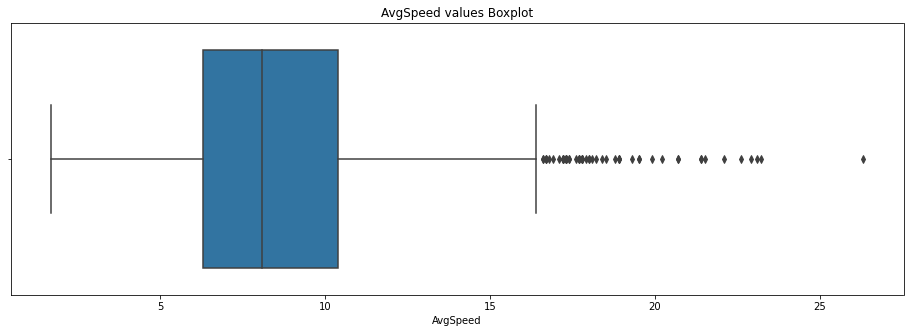

In [57]:
# Plot boxplot of AvgSpeed
plt.figure(figsize=(16,5));
sns.boxplot(weather['AvgSpeed']);
plt.title('AvgSpeed values Boxplot');

plt.show();

As the 'AvgSpeed' column is a range of continuous numbers with the majority of the values concentrated between approximately 1 to 16. We will take the median value to impute into the NULL cells.

In [58]:
# Fill all NULL values with the median value
weather['AvgSpeed'] = weather['AvgSpeed'].fillna(weather['AvgSpeed'].median())

# Check whether there is still null value
print(weather['AvgSpeed'].isnull().sum())

# Recheck the unique values in AvgSpeed
np.unique(weather['AvgSpeed'])

0


array([ 1.7,  1.9,  2. ,  2.1,  2.3,  2.4,  2.6,  2.7,  2.8,  2.9,  3. ,
        3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,
        4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,
        5.3,  5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,
        6.4,  6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,
        7.5,  7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,
        8.6,  8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,
        9.7,  9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7,
       10.8, 10.9, 11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8,
       11.9, 12. , 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9,
       13. , 13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. ,
       14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1,
       15.2, 15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16. , 16.1, 16.2,
       16.3, 16.4, 16.6, 16.7, 16.8, 16.9, 17.1, 17

##### 8. The column 'PrecipTotal'

In [59]:
# Check the data type of PrecipTotal
weather['PrecipTotal'].dtype

dtype('O')

In [60]:
# Checking on the value counts of values in PrecipTotal
weather['PrecipTotal'].value_counts()

0.00    1577
  T      318
0.01     127
0.02      63
0.03      46
        ... 
1.19       1
1.25       1
1.90       1
0.91       1
1.21       1
Name: PrecipTotal, Length: 167, dtype: int64

In the PrecipTotal column, there are values labelled as "T", which indicates traces of snowfall but too little for its value to be recorded accurately in numbers. 

In this case, we have chosen to change all values of "T" to the average between the lowest (0.00) and second lowest value (0.01) so as to leave an indication that there was snow on that day. This means we will change all "T" values to 0.005.

In [61]:
# Change all "T" to 0.005
weather['PrecipTotal'] = weather['PrecipTotal'].apply(lambda value: 0.005 if 'T' in str(value) else value)

# Recheck on the value counts of values in PrecipTotal
weather['PrecipTotal'].value_counts()

0.00     1577
0.005     318
0.01      127
0.02       63
0.03       46
         ... 
3.07        1
1.75        1
4.73        1
2.76        1
0.62        1
Name: PrecipTotal, Length: 167, dtype: int64

The 'PrecipTotal' column's values are still all in str format. For better visualisation during plotting, we will change the data type of the values to float.

In [62]:
# Changing the data types from str to float
weather['PrecipTotal'] = weather['PrecipTotal'].map(lambda value: float(value) if value != np.nan else value)

In [63]:
# Check again the data type of AvgSpeed
weather['PrecipTotal'].dtype

dtype('float64')

Before imputating any empty values in PrecipTotal, we will take a look at the distribution of the values in the PrecipTotal column.

In [64]:
# Checking the info on Preciptotal
weather['PrecipTotal'].describe()

count    2942.000000
mean        0.131869
std         0.393150
min         0.000000
25%         0.000000
50%         0.000000
75%         0.060000
max         6.860000
Name: PrecipTotal, dtype: float64

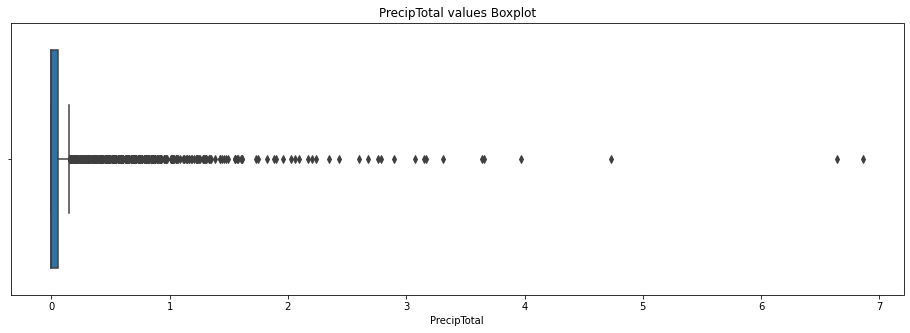

In [65]:
# Plot boxplot of PrecipTotal
plt.figure(figsize=(16,5));
sns.boxplot(weather['PrecipTotal']);
plt.title('PrecipTotal values Boxplot');

plt.show();

From the boxplot above, we see that PrecipTotal is a range of continuous numbers and is extremely spread out. However, the majority of the values are approximately 0.00 (the 50th percentile is also 0.00).

Therefore, we will impute the NULL values with 0.00 since it is overwhelmingly the most frequent value to appear.

In [66]:
# Fill all NULL values with the median value
weather['PrecipTotal'] = weather['PrecipTotal'].fillna(0.00)

# Check whether there is still null value
print(weather['PrecipTotal'].isnull().sum())

# Recheck the unique values in PrecipTotal
np.unique(weather['PrecipTotal'])

0


array([0.00e+00, 5.00e-03, 1.00e-02, 2.00e-02, 3.00e-02, 4.00e-02,
       5.00e-02, 6.00e-02, 7.00e-02, 8.00e-02, 9.00e-02, 1.00e-01,
       1.10e-01, 1.20e-01, 1.30e-01, 1.40e-01, 1.50e-01, 1.60e-01,
       1.70e-01, 1.80e-01, 1.90e-01, 2.00e-01, 2.10e-01, 2.20e-01,
       2.30e-01, 2.40e-01, 2.50e-01, 2.60e-01, 2.70e-01, 2.80e-01,
       2.90e-01, 3.00e-01, 3.10e-01, 3.20e-01, 3.30e-01, 3.40e-01,
       3.50e-01, 3.60e-01, 3.70e-01, 3.80e-01, 3.90e-01, 4.00e-01,
       4.10e-01, 4.20e-01, 4.30e-01, 4.40e-01, 4.50e-01, 4.60e-01,
       4.70e-01, 4.80e-01, 4.90e-01, 5.00e-01, 5.10e-01, 5.20e-01,
       5.30e-01, 5.40e-01, 5.50e-01, 5.60e-01, 5.70e-01, 5.80e-01,
       5.90e-01, 6.00e-01, 6.10e-01, 6.20e-01, 6.30e-01, 6.40e-01,
       6.50e-01, 6.60e-01, 6.70e-01, 6.80e-01, 6.90e-01, 7.00e-01,
       7.10e-01, 7.20e-01, 7.30e-01, 7.40e-01, 7.50e-01, 7.60e-01,
       7.70e-01, 7.80e-01, 7.90e-01, 8.00e-01, 8.10e-01, 8.20e-01,
       8.30e-01, 8.40e-01, 8.50e-01, 8.60e-01, 8.70e-01, 8.80e

### 2. Check Data Types

In [67]:
# Check through the data types of columns and cross-check with data dictionary given
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   float64
 5   DewPoint     2944 non-null   int64  
 6   WetBulb      2944 non-null   float64
 7   Heat         2944 non-null   float64
 8   Cool         2944 non-null   float64
 9   CodeSum      2944 non-null   object 
 10  PrecipTotal  2944 non-null   float64
 11  StnPressure  2944 non-null   float64
 12  SeaLevel     2944 non-null   float64
 13  ResultSpeed  2944 non-null   float64
 14  ResultDir    2944 non-null   int64  
 15  AvgSpeed     2944 non-null   float64
dtypes: float64(9), int64(5), object(2)
memory usage: 368.1+ KB


The numerical columns which originally had NULL values have been cleaned up and changed to the appropriate data types.

### 3. Feature Engineering

In [68]:
# Print a few rows to see the dataframe
weather.head()

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67.0,51,56.0,0.0,2.0,,0.0,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68.0,51,57.0,0.0,3.0,,0.0,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51.0,42,47.0,14.0,0.0,BR,0.0,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52.0,42,47.0,13.0,0.0,BR HZ,0.0,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56.0,40,48.0,9.0,0.0,,0.0,29.39,30.12,11.7,7,11.9


#### Drop Columns to Reduce Multi-Collinearity

From weather documentation, we observe that values of Tavg is derived from both the Tmax and Tmin column where an average of the 2 are taken. Thus, we will drop the Tmax and Tmin columns to reduce multicollinearity as the Tavg column alone will suffice.

In [69]:
# Dropping Tmax and Tmin columns and keep Tavg to reduce multicollinearity between Tmax, Tmin and Tavg
weather.drop(columns=['Tmax', 'Tmin'], inplace=True)

From weather documentation, we observe that values of Cool and Heat columns are both derived from the Tavg column where the base is 65 Fahrenheit. Thus, we will drop the Cool and Heat columns to reduce multicollinearity as the Tavg column alone will suffice.

In [70]:
# Dropping Cool and Heat columns and keep Tavg to reduce multicollinearity between Cool, Heat and Tavg
weather.drop(columns=['Cool', 'Heat'], inplace=True)

#### Modifications of Columns

Next, we will look at the remaining columns and perform feature engineering on them wherever possible.
1. CodeSum
2. Date

##### 1. The column 'CodeSum'

In [71]:
# Check the unique values in CodeSum
np.unique(weather['CodeSum'])

array([' ', 'BCFG BR', 'BR', 'BR HZ', 'BR HZ FU', 'BR HZ VCFG', 'BR VCTS',
       'DZ', 'DZ BR', 'DZ BR HZ', 'FG BR HZ', 'FG+', 'FG+ BCFG BR',
       'FG+ BR', 'FG+ BR HZ', 'FG+ FG BR', 'FG+ FG BR HZ', 'FG+ MIFG BR',
       'FU', 'HZ', 'HZ FU', 'HZ VCTS', 'MIFG BCFG BR', 'RA', 'RA BCFG BR',
       'RA BR', 'RA BR FU', 'RA BR HZ', 'RA BR HZ FU', 'RA BR HZ VCFG',
       'RA BR HZ VCTS', 'RA BR SQ', 'RA BR VCFG', 'RA BR VCTS', 'RA DZ',
       'RA DZ BR', 'RA DZ BR HZ', 'RA DZ FG+ BCFG BR', 'RA DZ FG+ BR',
       'RA DZ FG+ BR HZ', 'RA DZ FG+ FG BR', 'RA DZ SN', 'RA FG BR',
       'RA FG+ BR', 'RA FG+ MIFG BR', 'RA HZ', 'RA SN', 'RA SN BR',
       'RA VCTS', 'TS', 'TS BR', 'TS BR HZ', 'TS HZ', 'TS RA', 'TS RA BR',
       'TS RA BR HZ', 'TS RA FG+ FG BR', 'TS TSRA', 'TS TSRA BR',
       'TS TSRA BR HZ', 'TS TSRA GR RA BR', 'TS TSRA HZ', 'TS TSRA RA',
       'TS TSRA RA BR', 'TS TSRA RA BR HZ', 'TS TSRA RA BR HZ VCTS',
       'TS TSRA RA BR VCTS', 'TS TSRA RA FG BR', 'TS TSRA RA FG BR HZ',
 

The CodeSum column summarises the weather on the day the data was recorded. The abbreviations for the different CodeSum weathers are listed below:

|Abbreviation|Weather|
|:--:|:--:|
|+FC|TORNADO/WATERSPOUT|
|FC|FUNNEL CLOUD|
|TS|THUNDERSTORM|
|GR|HAIL|
|RA|RAIN|
|DZ|DRIZZLE|
|SN|SNOW|
|SG|SNOW GRAINS|
|GS|SMALL HAIL &/OR SNOW PELLETS|
|PL|ICE PELLETS|
|IC|ICE CRYSTALS|
|FG+|HEAVY FOG (FG & LE.25 MILES VISIBILITY)|
|FG|FOG|
|BR|MIST|
|UP|UNKNOWN PRECIPITATION|
|HZ|HAZE|
|FU|SMOKE|
|VA|VOLCANIC ASH|
|DU|WIDESPREAD DUST|
|DS|DUSTSTORM|
|PO|SAND/DUST WHIRLS|
|SA|SAND|
|SS|SANDSTORM|
|PY|SPRAY|
|SQ|SQUALL|
|DR|LOW DRIFTING|
|SH|SHOWER|
|FZ|FREEZING|
|MI|SHALLOW|
|PR|PARTIAL|
|BC|PATCHES|
|BL|BLOWING|
|VC|VICINITY|
||-   LIGHT|
||+   HEAVY|
|"NO SIGN"|MODERATE|


Mosquitoes thrive in areas where it is is hot and humid. Water is also required for them to lay eggs and reproduce. ([Terminix](https://www.terminix.com/pest-control/mosquitoes/life-cycle/breeding/), [ElevatePestControl](https://elevatepestcontrol.com/mosquito-faqs/what-type-of-water-does-a-mosquito-need-to-breed/))

Therefore, for our analysis, we will break down the CodeSum column into 2 categories that we want to focus our attention on: Wet or Dry.

For ease of modelling and visualisations, we will represent the Wet and Dry conditions in numerical format:
* Wet = 1
* Dry = 0

In [72]:
# Categorizing the different weathers into wet or dry

# Initiate empty list to store 1 or 0, for use to create new wet_dry column
wet_dry_list = []

# List of all abbreviations that can be categorised into wet
# note that we will remove the "+" signs so it is not included
wet_codesums = ['FC', 'TS', 'RA', 'DZ', 'FG', 'BR', 'UP', 'SH']

for code in weather['CodeSum']:
    
    # replace "+" and "-" sign with a space
    code.replace('+', ' ')
    code.replace('-', ' ')
    
    # set initial wet_dry value to 0 (dry), if found to be wet then change to 1 (wet) later
    check_wet = 0
    
    # iterate through wet_codesums to find matches
    for condition in wet_codesums:
        
        # check if regex search turns up with a match --> if no match, will return None
        check_search = re.search(condition, code)
        
        # if there is a match in regex search, wet wet_dry value to 1 (wet) and stop iterating through wet_codesums
        if check_search != None:
            check_wet = 1
            break

    # append current row's wet_dry value to list, for adding into dataframe later
    wet_dry_list.append(check_wet)

In [73]:
# Store the list into column 'wet_dry'
weather['wet_dry'] = wet_dry_list

# Print the value_count
weather['wet_dry'].value_counts()

# 1650 entries are 0 (dry), 1294 entries are 1 (wet).

0    1650
1    1294
Name: wet_dry, dtype: int64

In [74]:
weather.head()

,Station,Date,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,wet_dry
0,1,2007-05-01,67.0,51,56.0,,0.0,29.10,29.82,1.7,27,9.2,0
1,2,2007-05-01,68.0,51,57.0,,0.0,29.18,29.82,2.7,25,9.6,0
2,1,2007-05-02,51.0,42,47.0,BR,0.0,29.38,30.09,13.0,4,13.4,1
3,2,2007-05-02,52.0,42,47.0,BR HZ,0.0,29.44,30.08,13.3,2,13.4,1
4,1,2007-05-03,56.0,40,48.0,,0.0,29.39,30.12,11.7,7,11.9,0


As such, we proceed to drop the CodeSum column as wet_dry column has modified the CodeSum column, and therefore not needed anymore.

In [75]:
# Dropping Cool and Heat columns and keep Tavg to reduce multicollinearity between Cool, Heat and Tavg
weather.drop(columns=['CodeSum'], inplace=True)

##### 2. The column 'Date'

In [76]:
# Check the data type of Date
weather['Date'].dtype

dtype('O')

In [77]:
# Convert Date to datetime format
weather['Date'] = pd.to_datetime(weather['Date'])

In [78]:
# From 'Date', extract and add week, month and Year columns
weather['Week'] = (weather['Date'].dt.strftime('%W')).astype(int)
weather['Month'] = (weather['Date'].dt.strftime('%m')).astype(int)
weather['Year'] = (weather['Date'].dt.strftime('%Y')).astype(int)

In [79]:
# Define a function to concatenate the Year and month together and convert them into integer
def year_month(row):
    month = row['Month']
    year = row['Year']
    row['YearMonth'] = f'{year}{month}'
    row['YearMonth'] = int(row['YearMonth'])
    return row

In [80]:
# Define a function to concatenate the Year and Week together and convert them into integer
def year_week(row):
    week = row['Week']
    year = row['Year']
    row['YearWeek'] = f'{year}{week}'
    row['YearWeek'] = int(row['YearWeek'])
    return row

In [81]:
# Apply the 2 functions above to our dataset
weather = weather.apply(year_month, axis=1)
weather = weather.apply(year_week, axis=1)

## 4. Lowercasing Column Names

In [82]:
# Rename temperature column
weather.rename(columns={'Tavg': 't_avg'}, inplace=True)

# Renaming all columns except temperature
for col in weather.columns:
    
    #regex to split the words in the column name by capital letters
    new = re.findall('[a-zA-Z][^A-Z]*', col)
    
    #join the column name together with underscore and lowercase them
    new = '_'.join(new).lower()
    
    #rename the columns
    weather.rename(columns={col: new}, inplace=True)

## Save the Clean Dataset

In [83]:
# Save the clean dataset
weather.to_csv("../assets/weather_cleaned.csv", index = False)

In [84]:
%store weather

Stored 'weather' (DataFrame)
